In [581]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime


import warnings 
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None

os.listdir()

['orders.csv',
 'test_locations.csv',
 'train_locations.csv',
 'vendors.csv',
 '.ipynb_checkpoints',
 'test_customers.csv',
 'train_customers.csv',
 "EDA of Akeed's Dataset.ipynb"]

In [444]:
#Call this function to analyze each feature and find what are the classes inside it and how much of it is missing
#Also to figure out if the values in that feature are different or the same as it the case for features.

def FeatureDetails(data,feature):
    
    x = data[feature]
    y = set(x)
    print(f"Feature '{feature}' with len = {len(x)}")
    print(f"   Classes ({len(y)}): {list(y)}")
    print(f"   Classes counts:")
    print(x.value_counts())
    print(f"   Null Values: {x.isnull().sum()}, Null percentage: {x.isnull().sum()/len(x) *100}%")
    

# Train_locations Dataset

In [405]:
train_locations = pd.read_csv('train_locations.csv')

#After further exploration, we found that lat and longitude have been masked and changed probably for privacy purpoes
#Therefore, we are going to drop them from the model
train_locations.drop(['latitude','longitude'],axis=1,inplace=True)

train_locations.head(5)

,customer_id,location_number,location_type
0,02SFNJH,0,NaN
1,02SFNJH,1,NaN
2,02SFNJH,2,NaN
3,RU43CXC,0,Home
4,BDFBPRD,0,NaN


In [406]:
FeatureDetails(train_locations,'location_type')

Feature 'location_type' with len = 59503
   Classes (4): [nan, 'Home', 'Work', 'Other']
   Classes counts:
Home     19703
Work      6441
Other     6150
Name: location_type, dtype: int64
   Null Values: 27209, Null percentage: 45.72710619632623%


In [407]:
#for the beginning let's assign a value to Null to see what location_number are missing
train_locations.fillna('Null',inplace=True)

pd.crosstab(train_locations.location_number,train_locations.location_type,margins=True).style.background_gradient('plasma')

location_type,Home,Null,Other,Work,All
location_number,,,,,
0,12288,15238,3922,3952,35400
1,4229,6876,1314,1379,13798
2,1617,2855,463,553,5488
3,778,1230,233,278,2519
4,397,516,104,136,1153
5,155,224,54,71,504
6,89,109,20,28,246
7,42,59,13,14,128
8,30,28,6,12,76


In [408]:
#let's see if Null users has only one location First we need to see if the user has multiple addresses or not
train_locations['locations'] = 0

CID_count = {}
for i in range(len(train_locations)):
    CID = train_locations['customer_id'][i]
    if CID in CID_count:
        CID_count[CID] +=1
    else: 
        CID_count[CID] = 1

        
#We see that there are a lot of locations, how about we shorten them to 1, 2,3 ,4 ,5 where 5 is basically 5+ 

for idx, cid in enumerate(train_locations['customer_id']):
    if CID_count[cid] < 5:
        train_locations['locations'][idx] = CID_count[cid]
    else:
        train_locations['locations'][idx] = 5
train_locations.head()

,customer_id,location_number,location_type,locations
0,02SFNJH,0,Null,3
1,02SFNJH,1,Null,3
2,02SFNJH,2,Null,3
3,RU43CXC,0,Home,1
4,BDFBPRD,0,Null,1


Assumptions:

(1) - If they have only one address and it's Null -> it would become Home

(2) - If the first one is home, then assume the second is Work if Null and the vice versa

(3) - Third or more location assume others 

In [409]:
train_locations.loc[(train_locations.location_type=='Null')&(train_locations.locations==1),'location_type'] = 'Home'
train_locations.loc[(train_locations.location_type=='Null')&(train_locations.locations>2),'location_type'] = 'Other'

In [410]:
for idx, cid in enumerate(train_locations['customer_id']):
    count = CID_count[cid]
    loc_numb = train_locations['location_number'][idx]
    
    if (count> 1) & (train_locations['location_type'][idx-loc_numb] == 'Home'):
        train_locations['location_type'][idx] = 'Work'
    elif (count> 1) & (train_locations['location_type'][idx-loc_numb] == 'Work'):
        train_locations['location_type'][idx] = 'Home'
    elif (count> 1) & (train_locations['location_type'][idx-loc_numb] == 'Null'):
        train_locations['location_type'][idx] = 'Other' 
        
# AFter this is cleaned any null convert to others 
train_locations.loc[(train_locations.location_type=='Null'),'location_type'] = 'Other'

In [411]:
pd.crosstab(train_locations.location_type,train_locations.locations,margins=True).style.background_gradient(cmap='plasma')

locations,1,2,3,4,5,All
location_type,,,,,,
Home,17172,5300,3523,2332,3208,31535
Other,2224,6709,3156,1831,2214,16134
Work,2206,4611,2228,1301,1488,11834
All,21602,16620,8907,5464,6910,59503


In [533]:
train_locations.head()

,customer_id,location_number,location_type,locations
0,02SFNJH,0,Other,3
1,02SFNJH,1,Other,3
2,02SFNJH,2,Other,3
3,RU43CXC,0,Home,1
4,BDFBPRD,0,Home,1


# Test Location Dataset

In [723]:
test_locations = pd.read_csv('test_locations.csv')

#After further exploration, we found that lat and longitude have been masked and changed probably for privacy purpoes
#Therefore, we are going to drop them from the model
test_locations.drop(['latitude','longitude'],axis=1,inplace=True)

test_locations.fillna('Null',inplace=True)

#let's see if Null users has only one location First we need to see if the user has multiple addresses or not
test_locations['locations'] = 0

CID_count_t = {}
for i in range(len(test_locations)):
    CID = test_locations['customer_id'][i]
    if CID in CID_count_t:
        CID_count_t[CID] +=1
    else: 
        CID_count_t[CID] = 1

        
#We see that there are a lot of locations, how about we shorten them to 1, 2,3 ,4 ,5 where 5 is basically 5+ 

for idx, cid in enumerate(test_locations['customer_id']):
    if CID_count_t[cid] < 5:
        test_locations['locations'][idx] = CID_count_t[cid]
    else:
        test_locations['locations'][idx] = 5



test_locations.loc[(test_locations.location_type=='Null')&(test_locations.locations==1),'location_type'] = 'Home'
test_locations.loc[(test_locations.location_type=='Null')&(test_locations.locations>2),'location_type'] = 'Other'


for idx, cid in enumerate(test_locations['customer_id']):
    count = CID_count_t[cid]
    loc_numb = test_locations['location_number'][idx]
    
    if (count> 1) & (test_locations['location_type'][idx-loc_numb] == 'Home'):
        test_locations['location_type'][idx] = 'Work'
    elif (count> 1) & (test_locations['location_type'][idx-loc_numb] == 'Work'):
        test_locations['location_type'][idx] = 'Home'
    elif (count> 1) & (test_locations['location_type'][idx-loc_numb] == 'Null'):
        test_locations['location_type'][idx] = 'Other' 
        
# AFter this is cleaned any null convert to others 
test_locations.loc[(test_locations.location_type=='Null'),'location_type'] = 'Other'


test_locations.head()



,customer_id,location_number,location_type,locations
0,Z59FTQD,0,Home,1
1,0JP29SK,0,Work,5
2,0JP29SK,1,Home,5
3,0JP29SK,2,Home,5
4,0JP29SK,3,Home,5


# Order dataset

In [524]:
orders = pd.read_csv('orders.csv')

#dropping reasons: vendor_discount_amount       -> most of the dataset >98% is one class
#                 : delivery_time -> We will create our own because the current is pretty wrong 

orders.drop(['created_at','vendor_discount_amount','promo_code_discount_percentage','delivery_date',
             'driver_accepted_time','ready_for_pickup_time','picked_up_time','delivery_time'
             
            ],axis=1,inplace=True)

orders.head(2)

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,order_accepted_time,delivered_time,vendor_id,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,105,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,294,0,Work,QS68UD8 X 0 X 294


In [618]:
orders.isnull().sum() / len(orders) * 100

akeed_order_id             0.051736
customer_id                0.000000
item_count                 0.000000
grand_total                0.000000
payment_mode               0.000000
promo_code                 0.000000
is_favorite                0.000000
is_rated                   0.000000
vendor_rating              0.000000
driver_rating              0.000000
deliverydistance           0.000000
preparationtime           41.063391
vendor_id                  0.000000
LOCATION_NUMBER            0.000000
LOCATION_TYPE              0.000000
CID X LOC_NUM X VENDOR     0.000000
delivery_time              0.000000
dtype: float64

In [525]:
#convert PromoCode to 0 and 1 , 1=promocode used , 0:No promo    
# orders.loc[(orders.promo_code.notnull()),'promo_code'] = 1    #This code must run before the second one 
# orders.loc[(orders.promo_code.isnull()),'promo_code'] = 0

In [540]:
#replace the locationtype with the ones from training_dataset()
cid_locType = {}
for i,locType in enumerate(train_locations['location_type']):
    cid0 = train_locations['customer_id'][i]
    if cid0 not in cid_locType:
        cid_locType[cid0] = {train_locations['location_number'][i]:locType}
    else:
        cid_locType[cid0][train_locations['location_number'][i]] = locType
        

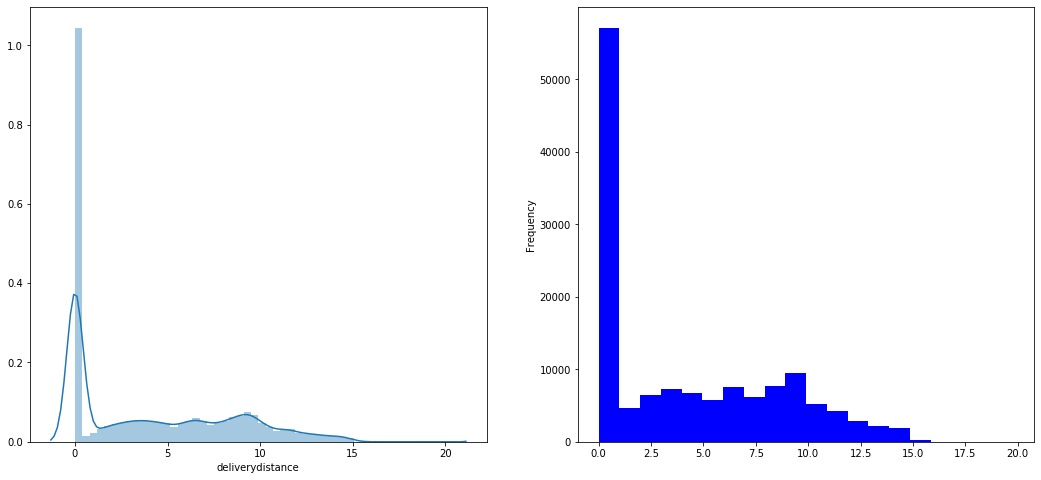

In [596]:
f,ax = plt.subplots(1,2,figsize=(18,8))
sns.distplot(orders['deliverydistance'], ax=ax[0])

orders.deliverydistance.plot.hist(ax=ax[1], bins = 20,color='b')

**The data shows that the majority delivery distance is 0 which is highly unlikely because that would assume the delivery is picked up and Akeed App doesn't do pickups**

In [710]:
55613/len(orders)

0.4110256239699046

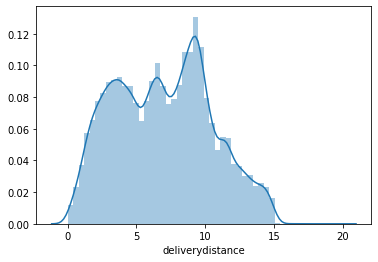

In [712]:
data2 = orders[orders['deliverydistance']!=0]
sns.distplot(data2['deliverydistance'])

In [715]:
set(pd.cut(data2['deliverydistance'],5))

{Interval(-0.0098, 3.97, closed='right'),
 Interval(3.97, 7.93, closed='right'),
 Interval(7.93, 11.89, closed='right'),
 Interval(11.89, 15.85, closed='right'),
 Interval(15.85, 19.81, closed='right')}

In [566]:
for i, cid in enumerate(orders['customer_id']):
    orders['LOCATION_TYPE'][i] = cid_locType[cid][orders['LOCATION_NUMBER'][i]]

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'

In [573]:
#For the time The important thing would the final delivery time so delivered time - dorder_accepted_time
orders['delivery_time'] = 0

for idx,oat in enumerate(orders['order_accepted_time']):
    time1 = oat
    time2 = orders['delivered_time'][idx]
    if (type(time2) != float) and (type(time1) != float):
        time1 = datetime.strptime(time1, "%Y-%m-%d %H:%M:%S")
        time2 = datetime.strptime(time2, "%Y-%m-%d %H:%M:%S")
        orders['delivery_time'][idx] = time2-time1
        
        

In [620]:
#now we have delivery time, we don't need delivered_time and order_accepted_time
#also prep time
orders.drop(['order_accepted_time','delivered_time','preparationtime'
            ],axis=1,inplace=True)

In [527]:
FeatureDetails(orders,'is_favorite')

#if is not null, then it is obvious that it's most likely not the favorite so -> No
#Also convert No -> 0 and Yes -> 1
orders.loc[(orders.is_favorite.isnull()),'is_favorite'] = 0
orders.loc[(orders.is_favorite == 'No'),'is_favorite'] = 0
orders.loc[(orders.is_favorite == 'Yes'),'is_favorite'] = 1

Feature 'is_favorite' with len = 135303
   Classes (3): [nan, 'No', 'Yes']
   Classes counts:
No     98449
Yes     1659
Name: is_favorite, dtype: int64
   Null Values: 35195, Null percentage: 26.01198790861991%


In [528]:
#for the items count we can put the average order instead 
import math 
math.floor(orders.item_count.mean())

orders['item_count'].fillna(2,inplace=True)

In [616]:
orders[orders['vendor_rating'].isnull()]['is_rated'].value_counts()
#we can see that is_rated -> vendor rating is redundent -> let's add another class in the vendor_rating for no rating
# -1 for no rating

orders['vendor_rating'].fillna(-1,inplace=True)

# Vendors Dataset

In [660]:
vendors = pd.read_csv('vendors.csv')

#Drop reasons: is_akeed_delivering, display_orders, country_id,city_id ,one_click_vendor,open_close_flags-> all values are the same
#            : is_open, -> we have opening time
#            : status, -> redundent like status
#            : device_type -> 99 are the same, one is only different, model won't learn much
#            : all the detailed opening times
#            : vendor_category_en -> we have vendor_category_id (restaurent, sweet and cake)
#            : commission -> it's either 0 or NAN so same value
#.           : created_at , updated_at -> no relation whatsoever 

vendors.drop(['is_akeed_delivering','status','vendor_category_en','verified','display_orders','device_type',
              'sunday_from_time1','sunday_to_time1','sunday_from_time2','sunday_to_time2',
              'monday_from_time1','monday_to_time1','monday_from_time2','monday_to_time2',
              'tuesday_from_time1','tuesday_to_time1','tuesday_from_time2','tuesday_to_time2',
              'wednesday_from_time1','wednesday_to_time1','wednesday_from_time2','wednesday_to_time2',
              'thursday_from_time1','thursday_to_time1','thursday_from_time2','thursday_to_time2',
              'friday_from_time1','friday_to_time1','friday_from_time2','friday_to_time2',
              'saturday_from_time1','saturday_to_time1','saturday_from_time2','saturday_to_time2',
              'country_id','city_id',"is_open",'commission','one_click_vendor','created_at','updated_at','latitude',
              'longitude','open_close_flags'
             ],axis=1,inplace=True) 
vendors.head(2)

,id,authentication_id,vendor_category_id,delivery_charge,serving_distance,OpeningTime,OpeningTime2,prepration_time,discount_percentage,rank,language,vendor_rating,primary_tags,vendor_tag,vendor_tag_name
0,4,118597.0,2.0,0.0,6.0,11:00AM-11:30PM,-,15,0.0,11,EN,4.4,"{""primary_tags"":""4""}","2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver..."
1,13,118608.0,2.0,0.7,5.0,08:30AM-10:30PM,-,14,0.0,11,EN,4.7,"{""primary_tags"":""7""}","4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa..."


In [661]:
#Need more details analysis on vendor_tag_name


In [662]:
FeatureDetails(vendors,'rank')

#Let's keep 1 to 1 and convert 11 to 1
vendors.loc[(vendors.rank == 11)&(vendors.id >0 ),'rank'] = 0

Feature 'rank' with len = 100
   Classes (2): [1, 11]
   Classes counts:
11    89
1     11
Name: rank, dtype: int64
   Null Values: 0, Null percentage: 0.0%


In [663]:
FeatureDetails(vendors,'prepration_time')

#Let's change the classes to be more structured 5 , 10 ,15,20 and 45 
vendors.loc[(vendors.prepration_time >10)&(vendors.prepration_time <16),'prepration_time'] = 15
vendors.loc[(vendors.prepration_time >15)&(vendors.prepration_time <22),'prepration_time'] = 20

Feature 'prepration_time' with len = 100
   Classes (14): [5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 45]
   Classes counts:
15    36
10    25
14     7
17     6
13     5
11     5
16     4
20     3
19     2
18     2
12     2
45     1
21     1
5      1
Name: prepration_time, dtype: int64
   Null Values: 0, Null percentage: 0.0%


In [664]:
FeatureDetails(vendors,'delivery_charge')

##Since the delivery is either free or 0.7 we leave zero as it is and convert 0.7 to 1 
vendors.loc[vendors.delivery_charge ==0.7,'delivery_charge'] = 1

Feature 'delivery_charge' with len = 100
   Classes (2): [0.0, 0.7]
   Classes counts:
0.7    59
0.0    41
Name: delivery_charge, dtype: int64
   Null Values: 0, Null percentage: 0.0%


In [666]:
#Let's clean and feature engineer opening times 
#first let's change "-" to None
vendors.loc[vendors.OpeningTime2 =='-','OpeningTime2'] = None

#Let's check the ones with OpeningTime2 not null 
vendors[vendors['OpeningTime2'].notnull()]

,id,authentication_id,vendor_category_id,delivery_charge,serving_distance,OpeningTime,OpeningTime2,prepration_time,discount_percentage,rank,language,vendor_rating,primary_tags,vendor_tag,vendor_tag_name
15,81,118678.0,2.0,0.0,15.0,08:00AM-12:30PM,05:00PM-11:30PM,15,0.0,11,EN,3.8,NaN,"2,4,8,53,13,24,16","Arabic,Breakfast,Desserts,Mandazi,Omani,Salads..."
34,157,118755.0,2.0,1.0,15.0,10:59AM-3:30PM,06:30PM-11:00PM,15,0.0,11,EN,4.3,"{""primary_tags"":""297""}","31,8,10,33,67,21","Biryani,Desserts,Indian,Rice,Thali,Vegetarian"
37,161,118759.0,2.0,1.0,10.0,11:00AM-11:59PM,12:00AM-01:00AM,20,0.0,11,EN,4.2,NaN,"5,8,63,15","Burgers,Desserts,Pastry,Pizzas"
45,195,118793.0,2.0,1.0,15.0,05:30PM-11:59PM,00:01AM-02:30AM,15,0.0,11,EN,4.2,NaN,"5,30,22,47,52,16,56","Burgers,Fries,Grills,Mishkak,Mojitos ,Sandwich..."
46,196,118794.0,3.0,1.0,10.0,06:00PM-11:59PM,00:01AM-02:30AM,20,0.0,11,EN,4.4,NaN,NaN,NaN
49,201,118800.0,2.0,1.0,15.0,11:00AM-3:50pm,6:10pm-12:00am,15,0.0,11,EN,4.0,NaN,"31,8,10,28","Biryani,Desserts,Indian,Soups"
51,207,118806.0,2.0,1.0,15.0,11:00AM-04:00PM,06:00PM-11:45PM,15,0.0,11,EN,4.1,NaN,"2,31,7,22,10,33,24,28,19","Arabic,Biryani,Chinese,Grills,Indian,Rice,Sala..."
55,231,118830.0,3.0,1.0,10.0,9am-10pm,10pm-11pm,15,0.0,11,EN,4.3,NaN,NaN,NaN
56,237,118838.0,2.0,1.0,15.0,08:30PM-11:59PM,00:01AM-02:30AM,15,0.0,11,EN,4.6,NaN,"1,5,8,57,30,27,24,16","American,Burgers,Desserts,Donuts,Fries,Pasta,S..."
57,243,118844.0,2.0,1.0,15.0,01.00PM-02:.00AM,01.00PM-02.00AM,15,0.0,11,EN,4.4,NaN,NaN,NaN


In [667]:
FeatureDetails(vendors,'OpeningTime')

Feature 'OpeningTime' with len = 100
   Classes (69): [nan, '11:00AM-11:59PM', '09:00AM-08:00pm ', '11:59AM-11:59PM', '11:15AM-10:00PM', '12:00PM-11:59PM', '08:00AM-11:59PM', '9am-10pm', '10:00AM-11:15PM', '8:00AM-09:45PM', '08:30AM-11:45PM', '08:30PM-11:59PM', '11:00AM-11:00PM', '10:59AM-10:30PM', '11:00AM-10:45PM', '10:59AM-10:59PM', '11:59AM-10:45PM', '11AM-11PM', '9-22', '06:00PM-11:59PM', '08:00AM-11:00PM', '10:59AM-3:30PM', '05:00PM-11:45PM', '01.00PM-02:.00AM', '08:00AM-10:45PM', '10:00AM-11:45PM', '10:00AM-11:00PM', '9:00AM-11:00PM', '04:59PM-11:45PM', '08:00AM-3:30PM', '10:59AM-11:30PM', '11:15AM-10:30PM', '08:00AM-11:45-', '11:00AM-12:00PM', '05:00PM-11:00PM', '7:58AM-11:45PM', '05:00PM-11:59PM ', '09:00 AM-11:45 PM', '09:00AM-11:59PM', '08:30AM-09:30PM', '08:00AM-12:30PM', '09:00AM-09:01AM', '11:00AM-11:01PM', '11:59AM-2:15 am', '08:30AM-10:30PM', '11:00AM-3:50pm', '09:00AM-11:45PM', '09:00AM-07:00PM', '09:00AM-11:30PM', '11.30am-11:30PM', '11:59AM-10:45PM ', '06:15AM-11:45P

In [668]:
opt1 = vendors["OpeningTime"].str.split("-", n = 1, expand = True) 
vendors['ot1'] = opt1[0]
vendors['ot2'] = opt1[1]
vendors.drop(['OpeningTime'],axis=1,inplace=True)

In [670]:
opt2 = vendors["OpeningTime2"].str.split("-", n = 1, expand = True) 
vendors['ot3'] = opt2[0]
vendors['ot4'] = opt2[1]
vendors.drop(['OpeningTime2'],axis=1,inplace=True)

In [707]:
vendors.head()

,id,authentication_id,vendor_category_id,delivery_charge,serving_distance,prepration_time,discount_percentage,rank,language,vendor_rating,primary_tags,vendor_tag,vendor_tag_name,ot1,ot2,ot3,ot4
0,4,118597.0,2.0,0.0,6.0,15,0.0,11,EN,4.4,"{""primary_tags"":""4""}","2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",11:00AM,11:30PM,None,None
1,13,118608.0,2.0,1.0,5.0,15,0.0,11,EN,4.7,"{""primary_tags"":""7""}","4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",08:30AM,10:30PM,None,None
2,20,118616.0,2.0,0.0,8.0,20,0.0,1,EN,4.5,"{""primary_tags"":""71""}","4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",08:00AM,10:45PM,None,None
3,23,118619.0,2.0,0.0,5.0,20,0.0,11,EN,4.5,"{""primary_tags"":""46""}","5,8,30,24","Burgers,Desserts,Fries,Salads",10:59AM,10:30PM,None,None
4,28,118624.0,2.0,1.0,15.0,10,0.0,11,EN,4.4,"{""primary_tags"":""32""}",5,Burgers,11:00AM,11:45PM,None,None


In [704]:
type(vendors["ot3"][0])

NoneType

# Train_customers

In [391]:
train_customers = pd.read_csv('train_customers.csv')
train_customers.head(10)

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01
5,IL9MJSW,Male,NaN,1,1,EN,2018-03-16 18:22:00,2018-03-16 18:22:00
6,EZTXK46,Male,1957.0,1,1,EN,2018-03-16 21:46:19,2020-03-21 21:01:33
7,A79YCES,Male,NaN,1,1,EN,2018-03-22 16:48:06,2018-03-22 16:48:06
8,Y39V6UD,Male,NaN,1,1,EN,2018-03-22 19:55:54,2018-03-22 19:55:53
9,XRPTQNV,Male,NaN,1,1,EN,2018-03-25 11:36:30,2018-03-25 11:36:30


In [626]:
train_customers.isnull().sum() / len(train_customers)

akeed_customer_id    0.000000
gender               0.350522
dob                  0.912153
status               0.000000
verified             0.000000
language             0.391504
created_at           0.000000
updated_at           0.000000
dtype: float64

In [629]:
#91% of the data is missing so we are going to drop the dob, also created_at and updated at are unnecessary 
#Drop language becuase it's only English and no other class
train_customers.drop(['dob','language','created_at','updated_at'],axis=1,inplace =True)

In [628]:
train_customers['language'].value_counts()

EN    21099
Name: language, dtype: int64

In [631]:
FeatureDetails(train_customers,'gender')

Feature 'gender' with len = 34674
   Classes (11): ['Female', '  ', nan, 'Male  ', 'Female  ', 'male', 'Female    ', '?????', 'Male', 'Female   ', 'Female ']
   Classes counts:
Male          17815
male           2914
Female         1761
Female           13
Male              9
Female            2
?????             2
Female            2
                  1
Female            1
Name: gender, dtype: int64
   Null Values: 12154, Null percentage: 35.05220049604891%


In [649]:
#We need to clean and process the different classes and we will classify them as Male, Female and any null or missing data => Other
for idx, gender in enumerate(train_customers['gender']):
    if type(gender) == str:
        if 'Female' in gender:
            train_customers['gender'][idx] = 'female'
        elif 'Male' in gender:
            train_customers['gender'][idx] = 'male'
        else:
            train_customers['gender'][idx] = 'other'
    else:
        train_customers['gender'][idx] = 'other'


In [651]:
#Now it's cleaner
FeatureDetails(train_customers,'gender')

#let's convert it to 0,1,2     0-> female, 1-> male 2-> other
train_customers.loc[(train_customers['gender']=='female'),'gender'] = 0
train_customers.loc[(train_customers['gender']=='male'),'gender'] = 1
train_customers.loc[(train_customers['gender']=='other'),'gender'] = 2

Feature 'gender' with len = 34674
   Classes (3): ['male', 'female', 'other']
   Classes counts:
male      17824
other     15071
female     1779
Name: gender, dtype: int64
   Null Values: 0, Null percentage: 0.0%


# Train Customer Dataset

In [730]:
test_customers = pd.read_csv('test_customers.csv')
test_customers.drop(['dob','language','created_at','updated_at'],axis=1,inplace =True)

for idx, gender in enumerate(test_customers['gender']):
    if type(gender) == str:
        if 'Female' in gender:
            test_customers['gender'][idx] = 'female'
        elif 'Male' in gender:
            test_customers['gender'][idx] = 'male'
        else:
            test_customers['gender'][idx] = 'other'
    else:
        test_customers['gender'][idx] = 'other'

#let's convert it to 0,1,2     0-> female, 1-> male 2-> other
test_customers.loc[(test_customers['gender']=='female'),'gender'] = 0
test_customers.loc[(test_customers['gender']=='male'),'gender'] = 1
test_customers.loc[(test_customers['gender']=='other'),'gender'] = 2


## Final Results Datasets.head()


In [731]:
train_customers.head()

,akeed_customer_id,gender,status,verified
0,TCHWPBT,1,1,1
1,ZGFSYCZ,1,1,1
2,S2ALZFL,1,0,1
3,952DBJQ,1,1,1
4,1IX6FXS,1,1,1


In [732]:
test_customers.head()

,akeed_customer_id,gender,status,verified
0,ICE2DJP,1,1,1
1,FWNUI71,1,1,1
2,LRX7BCH,1,1,1
3,D96DHMD,1,1,1
4,88Q8Y5V,1,1,1


In [717]:
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,vendor_id,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR,delivery_time
0,163238.0,92PEE24,1.0,7.6,2,0,0,No,-1.0,0.0,0.0,105,0,Other,92PEE24 X 0 X 105,0
1,163240.0,QS68UD8,1.0,8.7,1,0,0,No,-1.0,0.0,0.0,294,0,Home,QS68UD8 X 0 X 294,0
2,163241.0,MB7VY5F,2.0,14.4,1,0,0,No,-1.0,0.0,0.0,83,0,Home,MB7VY5F X 0 X 83,0
3,163244.0,KDJ951Y,1.0,7.1,1,0,0,No,-1.0,0.0,0.0,90,0,Home,KDJ951Y X 0 X 90,0
4,163245.0,BAL0RVT,4.0,27.2,1,0,0,No,-1.0,0.0,0.0,83,0,Home,BAL0RVT X 0 X 83,0


In [719]:
vendors.head()

,id,authentication_id,vendor_category_id,delivery_charge,serving_distance,prepration_time,discount_percentage,rank,language,vendor_rating,primary_tags,vendor_tag,vendor_tag_name,ot1,ot2,ot3,ot4
0,4,118597.0,2.0,0.0,6.0,15,0.0,11,EN,4.4,"{""primary_tags"":""4""}","2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",11:00AM,11:30PM,None,None
1,13,118608.0,2.0,1.0,5.0,15,0.0,11,EN,4.7,"{""primary_tags"":""7""}","4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",08:30AM,10:30PM,None,None
2,20,118616.0,2.0,0.0,8.0,20,0.0,1,EN,4.5,"{""primary_tags"":""71""}","4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",08:00AM,10:45PM,None,None
3,23,118619.0,2.0,0.0,5.0,20,0.0,11,EN,4.5,"{""primary_tags"":""46""}","5,8,30,24","Burgers,Desserts,Fries,Salads",10:59AM,10:30PM,None,None
4,28,118624.0,2.0,1.0,15.0,10,0.0,11,EN,4.4,"{""primary_tags"":""32""}",5,Burgers,11:00AM,11:45PM,None,None


In [720]:
train_locations.head()

,customer_id,location_number,location_type,locations
0,02SFNJH,0,Other,3
1,02SFNJH,1,Other,3
2,02SFNJH,2,Other,3
3,RU43CXC,0,Home,1
4,BDFBPRD,0,Home,1
